# HR Analytics

## Introduction

### Phases of the Data Science experiment
1. Define your problem by Business Question
2. Gather data
3. Exploratory Data Analysis
4. Data preparation
5. Models creation
6. Models evaluation and finding the most suitable for the problem
7. Deployment and results presentation


#### Phase 1: Business Question

### Situation description
Current Employer that leads BigData&Analytics department provides free training for its employees that want to upskill in the Data domain. The Company as well as its HR Department want to know which employees should bne allowed to do the course to actually upskill them, but not to lose them afterwards.

### Business Questions
1. Will given employee change the job after we give him a DataScience training?
2. Based on which factors we should set a prioritization to provide the Data Science training?

#### Phase 2: Gather data

In [137]:
# Import packages

import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [138]:
df_hr = pd.read_csv("data/hr_data.csv", index_col='enrollee_id')

#### Phase 3: EDA

In [139]:
print(df_hr.columns)
print("")
print(df_hr.describe())

# Observation - 19158 records, 12 attributes and binary target, 
#   target = 0 means that employee after taking the training does not look for a job, 
#   target = 1 means they are actively searching for opportunities outside of the Company that provided him traning
# Conclusion - there is enough data to provide advanced analytics for binary classification

Index(['city', 'city_development_index', 'gender', 'relevent_experience',
       'enrolled_university', 'education_level', 'major_discipline',
       'experience', 'company_size', 'company_type', 'last_new_job',
       'training_hours', 'target'],
      dtype='object')

       city_development_index  training_hours        target
count            19158.000000    19158.000000  19158.000000
mean                 0.828848       65.366896      0.249348
std                  0.123362       60.058462      0.432647
min                  0.448000        1.000000      0.000000
25%                  0.740000       23.000000      0.000000
50%                  0.903000       47.000000      0.000000
75%                  0.920000       88.000000      0.000000
max                  0.949000      336.000000      1.000000


In [140]:
print("Null Check for Training Set:\n", df_hr.isna().any())
print("")
print("Null Check for Test Set:\n", df_hr.isna().any())

# Observation - both sets are having the same statistics against null values
# Conclusion - data has missing values that have to be analyzed and potentially preprocessed

Null Check for Training Set:
 city                      False
city_development_index    False
gender                     True
relevent_experience       False
enrolled_university        True
education_level            True
major_discipline           True
experience                 True
company_size               True
company_type               True
last_new_job               True
training_hours            False
target                    False
dtype: bool

Null Check for Test Set:
 city                      False
city_development_index    False
gender                     True
relevent_experience       False
enrolled_university        True
education_level            True
major_discipline           True
experience                 True
company_size               True
company_type               True
last_new_job               True
training_hours            False
target                    False
dtype: bool


In [141]:
print(df_hr['target'].value_counts())

# Observation - imbalanced set (0.25 vs 0.75)
# Conclusion - model average accuracy should be above 80% to provide any value

0.0    14381
1.0     4777
Name: target, dtype: int64


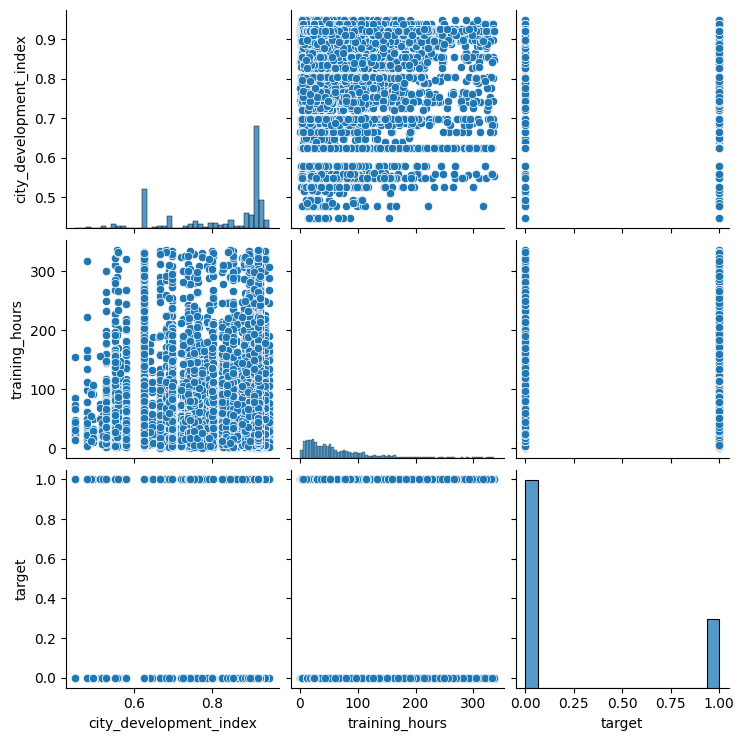

In [142]:
sns.pairplot(df_hr)

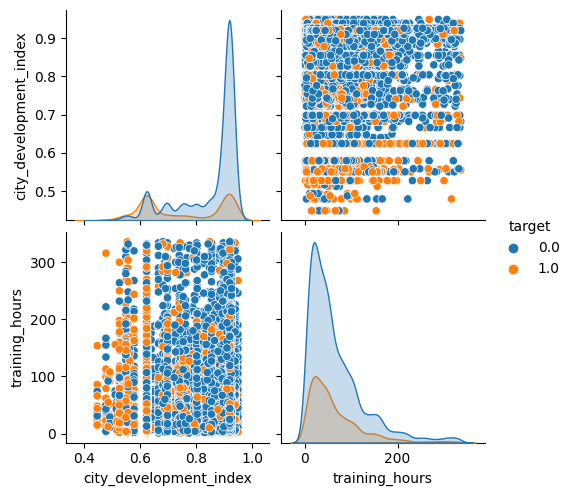

In [143]:
sns.pairplot(df_hr, hue='target')

# Observations:
#   Lower city development index means much more chance for Employee to actively look for a job change
#   In general number of training hours taken do not provide much information

#### Phase 4: Data Preparation

In [144]:
# As we are going to use classification algorithms we should test multiple data processing techniques, including none
df_hr_no_processing = df_hr.copy()
df_hr_processed = df_hr.copy()
df_hr_processed_and_scaled = df_hr.copy()

# Standard processing
add_logging = False

if add_logging:
    for col in df_hr_processed.columns:
        print("------\n", df_hr_processed[col].value_counts(), "\nNumber of distinct values:", len(set(df_hr_processed[col])))
        print("Number of missing values:", df_hr_processed[col].isnull().sum())
        if col in ['city_development_index', 'training_hours']:
            print("Values range:", df_hr_processed[col].min(), " - ", df_hr_processed[col].max())

""" 
Columns to be processed
    city - dummy
    city_development_index - nothing (no standarization needed)
    gender - dummy, other into gender_other, NaN into gender_unknown
    relevent_experience - switch to binary
    enrolled_university - dummy, missing values to be removed
    education_level - dummy, missing values to be removed
    major_discipline - dummy, other into major_discipline_other, missing values to be removed
    experience - bucketing, missing values to be removed
    company_size - bucketing, 10/49 -> 10-49, NaN -> -1
    company_type - dummy, Other -> company_type_Other
    last_new_job - bucketing, NaN -> last_new_job_unknown
    training_hours - nothing, optional standarization
"""
# No outliers detection required

# Change needed values
columns_with_missing_values = ["gender", "enrolled_university", "education_level", "major_discipline", "experience", "company_size", "last_new_job"]
columns_to_update = ["gender", "relevent_experience", "major_discipline", "company_size", "company_type"]
columns_to_bucketize = ["experience", "company_size", "last_new_job"]
columns_to_dummify = ["city", "gender", "enrolled_university", "education_level", "major_discipline", "company_type", "last_new_job"]
columns_to_standardize = ["training_hours"]

# Update missing values
df_hr_processed.loc[df_hr_processed["gender"].isnull(), "gender"] = "gender_unknown"
df_hr_processed.loc[df_hr_processed["company_size"].isnull(), "company_size"] = "-1"
df_hr_processed.loc[df_hr_processed["last_new_job"].isnull(), "last_new_job"] = "last_new_job_unknown"
df_hr_processed = df_hr_processed[df_hr_processed["enrolled_university"].notna()]
df_hr_processed = df_hr_processed[df_hr_processed["education_level"].notna()]
df_hr_processed = df_hr_processed[df_hr_processed["major_discipline"].notna()]
df_hr_processed = df_hr_processed[df_hr_processed["experience"].notna()]

if add_logging:
    for col in columns_with_missing_values:
        print(df_hr_processed[col].isna().sum())
        print(df_hr_processed[col].value_counts())


# Update invalid or improper values
df_hr_processed["gender"] = df_hr_processed["gender"].replace({
    "Other" : "gender_Other"
})

df_hr_processed["relevent_experience"] = df_hr_processed["relevent_experience"].replace({
    "No relevent experience" : 0,
    "Has relevent experience" : 1
})

df_hr_processed["major_discipline"] = df_hr_processed["major_discipline"].replace({
    "Other" : "gender_Other"
})

df_hr_processed["company_size"] = df_hr_processed["company_size"].replace({
    "10/49" : "10-49"
})

df_hr_processed["company_type"] = df_hr_processed["company_type"].replace({
    "Other" : "company_type_Other"
})



# Bucketing range values
df_hr_processed["experience"] = df_hr_processed["experience"].replace({
    "<1" : 0,
    ">20" : 21
})
df_hr_processed["experience"] = df_hr_processed["experience"].astype(int)
experience_bins = np.array([-1, 0, 1, 3, 5, 10, 20, 99])
df_hr_processed["experience"] = pd.cut(df_hr_processed["experience"], bins=experience_bins)
print(df_hr_processed["experience"].value_counts())


df_hr_processed["company_size"] = df_hr_processed["company_size"].replace({
           "-1" : -1,
          "<10" : 5,
        "10-49" : 30,
        "50-99" : 75,
      "100-500" : 300,
      "500-999" : 750,
    "1000-4999" : 3000,
    "5000-9999" : 7500,
       "10000+" : 50000
})
company_size_bins = np.array([-2, 0, 9, 49, 99, 999, 4999, 9999, 1000000000])
df_hr_processed["company_size"] = pd.cut(df_hr_processed["company_size"], bins=company_size_bins)
print(df_hr_processed["company_size"].value_counts())

# Dummify
## Last New Job - Amount of time can be the strongest discriminator so the decision is to use dummy values to create a vector out of it, experience may have a huge impact on mindset
df_hr_processed["last_new_job"] = df_hr_processed["last_new_job"].replace({
    "never" : "last_new_job_never",
        "1" : "last_new_job_1",
        "2" : "last_new_job_2",
        "3" : "last_new_job_3",
        "4" : "last_new_job_4",
       ">4" : "last_new_job_over_4",
})

df_hr_processed = pd.get_dummies(df_hr_processed, columns=columns_to_dummify)

if add_logging:
    print(df_hr_processed.columns)

print(df_hr_processed.shape)

# Observation: final shape: 16070 x 157


(5, 10]     4296
(10, 20]    4045
(20, 99]    3076
(3, 5]      2206
(1, 3]      1725
(0, 1]       372
(-1, 0]      350
Name: experience, dtype: int64
(-2, 0]               4104
(99, 999]             3167
(49, 99]              2761
(9999, 1000000000]    1888
(9, 49]               1299
(999, 4999]           1213
(0, 9]                1122
(4999, 9999]           516
Name: company_size, dtype: int64
(16070, 157)


In [145]:
# Optional training_hours standarization
df_hr_processed_and_scaled = df_hr_processed.copy()

# sns.boxplot(x=df_hr_processed_and_scaled["training_hours"])
# sns.histplot(df_hr_processed_and_scaled["training_hours"])

scaler = StandardScaler()
df_hr_processed_and_scaled["training_hours_new"] = scaler.fit_transform(df_hr_processed_and_scaled["training_hours"].to_numpy().reshape(-1, 1))

df_hr_processed_and_scaled.drop(columns=["training_hours"], inplace=True)
df_hr_processed_and_scaled.rename(columns={ "training_hours_new" : "training_hours" }, inplace=True)

# sns.boxplot(x=df_hr_processed_and_scaled["training_hours"])
# sns.histplot(df_hr_processed_and_scaled["training_hours"])


#### Phase 5: Model creation